# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [ ]:
from __future__ import print_function

import os
import skimage.io as io
import skimage.transform as trans
import shutil
import cv2
import matplotlib.pyplot as plt
import pickle
import time
import glob

import numpy as np
import keras
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from keras import backend as keras

from keras.layers import Dropout

from sklearn.externals import joblib
import argparse
from keras.callbacks import *
import sys
import theano
import theano.tensor as T
from keras import initializers
from keras.layers import BatchNormalization
import copy
import tensorflow as tf

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from tensorflow.keras.models import load_model as load_initial_model
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy

import gc

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.layers import concatenate, Conv2DTranspose, BatchNormalization
from keras import backend as K

## Handcrafted Metrics For Additional Evaluation and Loss Function

In [ ]:
def dice_coef(y_true, y_pred):
  smooth = 0.0
  y_true_f = keras.flatten(y_true)
  y_pred_f = keras.flatten(y_pred)
  intersection = keras.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

  y_true_f = keras.flatten(y_true)
  y_pred_f = keras.flatten(y_pred)
  intersection = keras.sum ( y_true_f * y_pred_f)
  union = keras.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

  return intersection/union

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def cross_entropy(p, q):
	  return -sum([p[i]*log2(q[i]) for i in range(len(p))])

## Squeeze U-Net Model

In [ ]:
def fire_module(x, fire_id, squeeze=16, expand=64):
    f_name = "fire{0}/{1}"
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(squeeze, (1, 1), activation='relu', padding='same', name=f_name.format(fire_id, "squeeze1x1"))(x)
    x = BatchNormalization(axis=channel_axis)(x)

    left = Conv2D(expand, (1, 1), activation='relu', padding='same', name=f_name.format(fire_id, "expand1x1"))(x)
    right = Conv2D(expand, (3, 3), activation='relu', padding='same', name=f_name.format(fire_id, "expand3x3"))(x)
    x = concatenate([left, right], axis=channel_axis, name=f_name.format(fire_id, "concat"))
    return x


def SqueezeUNet(inputs, num_classes=None, deconv_ksize=3, dropout=0.5, activation='sigmoid'):
    """SqueezeUNet is a implementation based in SqueezeNetv1.1 and unet for semantic segmentation
    :param inputs: input layer.
    :param num_classes: number of classes.
    :param deconv_ksize: (width and height) or integer of the 2D deconvolution window.
    :param dropout: dropout rate
    :param activation: type of activation at the top layer.
    :returns: SqueezeUNet model
    """
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    if num_classes is None:
        num_classes = K.int_shape(inputs)[channel_axis]

    x01 = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu', name='conv1')(inputs)
    x02 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1', padding='same')(x01)

    x03 = fire_module(x02, fire_id=2, squeeze=16, expand=64)
    x04 = fire_module(x03, fire_id=3, squeeze=16, expand=64)
    x05 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3', padding="same")(x04)

    x06 = fire_module(x05, fire_id=4, squeeze=32, expand=128)
    x07 = fire_module(x06, fire_id=5, squeeze=32, expand=128)
    x08 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5', padding="same")(x07)

    x09 = fire_module(x08, fire_id=6, squeeze=48, expand=192)
    x10 = fire_module(x09, fire_id=7, squeeze=48, expand=192)
    x11 = fire_module(x10, fire_id=8, squeeze=64, expand=256)
    x12 = fire_module(x11, fire_id=9, squeeze=64, expand=256)

    if dropout != 0.0:
        x12 = Dropout(dropout)(x12)

    up1 = concatenate([
        Conv2DTranspose(192, deconv_ksize, strides=(1, 1), padding='same')(x12),
        x10,
    ], axis=channel_axis)
    up1 = fire_module(up1, fire_id=10, squeeze=48, expand=192)

    up2 = concatenate([
        Conv2DTranspose(128, deconv_ksize, strides=(1, 1), padding='same')(up1),
        x08,
    ], axis=channel_axis)
    up2 = fire_module(up2, fire_id=11, squeeze=32, expand=128)

    up3 = concatenate([
        Conv2DTranspose(64, deconv_ksize, strides=(2, 2), padding='same')(up2),
        x05,
    ], axis=channel_axis)
    up3 = fire_module(up3, fire_id=12, squeeze=16, expand=64)

    up4 = concatenate([
        Conv2DTranspose(32, deconv_ksize, strides=(2, 2), padding='same')(up3),
        x02,
    ], axis=channel_axis)
    up4 = fire_module(up4, fire_id=13, squeeze=16, expand=32)
    up4 = UpSampling2D(size=(2, 2))(up4)

    x = concatenate([up4, x01], axis=channel_axis)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(num_classes, (1, 1), activation=activation)(x)
    model = Model(inputs, x)
    #model.summary()
    model.compile(optimizer=Adam(lr = 1e-4), loss=binary_crossentropy, metrics = ['accuracy',dice_coef,jacard,tf.keras.metrics.MeanIoU(num_classes=2),
                                                                                      tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
                                                                                      
    return model

## Generators

In [ ]:
def adjustData(img,mask,flag_multi_class,num_class):
  if(flag_multi_class):
    img = img / 255
    mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
    new_mask = np.zeros(mask.shape + (num_class,))
    for i in range(num_class):
        #for one pixel in the image, find the class in mask and convert it into one-hot vector
        #index = np.where(mask == i)
        #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
        #new_mask[index_mask] = 1
        new_mask[mask == i,i] = 1
    new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
    mask = new_mask
  elif (np.max(img) > 1):
    img = img / 255
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
  return (img,mask)

def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (512,512),seed = 1):
  image_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  image_generator = image_datagen.flow_from_directory(
      train_path,
      classes = [image_folder],
      class_mode = None,
      color_mode = image_color_mode,
      target_size = target_size,
      batch_size = batch_size,
      save_to_dir = save_to_dir,
      save_prefix  = image_save_prefix,
      seed = seed)
  mask_generator = mask_datagen.flow_from_directory(
      train_path,
      classes = [mask_folder],
      class_mode = None,
      color_mode = mask_color_mode,
      target_size = target_size,
      batch_size = batch_size,
      save_to_dir = save_to_dir,
      save_prefix  = mask_save_prefix,
      seed = seed)
  train_generator = zip(image_generator, mask_generator)
  for (img,mask) in train_generator:
    img,mask = adjustData(img,mask,flag_multi_class,num_class)
    yield (img,mask)

def testGenerator(KFOLD_TEMP_TEST, target_size = (512,512),flag_multi_class = False,as_gray = True):
  image_datagen = ImageDataGenerator(rescale=1./255)
  mask_datagen = ImageDataGenerator(rescale=1./255)

  for img_name in sorted(os.listdir(KFOLD_TEMP_TEST + "/images")):
      img = io.imread(os.path.join(KFOLD_TEMP_TEST + "/images",img_name),as_gray = as_gray)
      img = img / 255
      img = trans.resize(img,target_size)
      img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
      img = np.reshape(img,(1,)+img.shape)
      yield img

def testGenerator2(batch_size,test_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (512,512),seed = 1):
  image_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  image_generator = image_datagen.flow_from_directory(
      test_path,
      classes = [image_folder],
      class_mode = None,
      color_mode = image_color_mode,
      target_size = target_size,
      batch_size = batch_size,
      save_to_dir = save_to_dir,
      save_prefix  = image_save_prefix,
      seed = seed)
  mask_generator = mask_datagen.flow_from_directory(
      test_path,
      classes = [mask_folder],
      class_mode = None,
      color_mode = mask_color_mode,
      target_size = target_size,
      batch_size = batch_size,
      save_to_dir = save_to_dir,
      save_prefix  = mask_save_prefix,
      seed = seed)
  test_generator = zip(image_generator, mask_generator)
  for (img,mask) in test_generator:
    img,mask = adjustData(img,mask,flag_multi_class,num_class)
    yield (img,mask)


def saveResult(fold,k,save_path,npyfile,flag_multi_class = False,num_class = 2):
  for i,item in enumerate(npyfile):
      img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
      io.imsave(os.path.join(save_path,"%d_predict.png"%(i+fold*k)),img)

## The Training Function
* This function includes mkdir temporary directories and training module. 
* Global path variables defined below. 
* We recommend you that do not configure your code, configure your drive paths.
* If you launch this function one more time or more, you must delete files in RESULTS_PATH.

In [ ]:
"""
TRAIN_PATH_IMG  -> 30 img + augmented imgs (not k-fold cross validated)
TRAIN_PATH_MASK -> 30 mask + augmented masks (not k-fold cross validated)

KFOLD_TEMP_TRAIN -> Contains k-fold cross validated train images and masks
KFOLD_TEMP_TEST -> Contains k-fold cross validated test images and masks

LOG_PATH -> contains model history with pickle files
CKPTS_PATH -> for checkpoints
RESULTS_PATH -> containts predictions

You should create below paths by hand. We recommend you that do not configure your code, configure your paths.
When you launch all cells again, delete every file in RESULTS_PATH.
"""

TRAIN_PATH_IMG        = '/content/drive/MyDrive/data/augmentation/combinations-10aug/images' 
TRAIN_PATH_MASK       = '/content/drive/MyDrive/data/augmentation/combinations-10aug/labels'
KFOLD_TEMP_TRAIN      = '/content/drive/MyDrive/data/augmentation/temp_train'
KFOLD_TEMP_TEST       = '/content/drive/MyDrive/data/augmentation/temp_test'

LOG_PATH   = '/content/drive/MyDrive/data/augmentation/logs'
CKPTS_PATH = '/content/drive/MyDrive/data/augmentation/checkpoints'
RESULTS_PATH = '/content/drive/MyDrive/data/augmentation/results'


if (os.path.isdir(TRAIN_PATH_IMG) and os.path.isdir(TRAIN_PATH_MASK) and \
    os.path.isdir(KFOLD_TEMP_TRAIN) and os.path.isdir(KFOLD_TEMP_TEST) and os.path.isdir(LOG_PATH) and \
    os.path.isdir(CKPTS_PATH) and os.path.isdir(RESULTS_PATH)) == 0:
    raise OSError()

In [ ]:

def k_fold(epoch,train_batch_size,test_batch_size,k=5,show_samples=False,no_of_sample=300):
  """
  Parameters:
    - epoch: nof epochs for each fold
    - train_batch_size: batch size for training
    - test_batch_size: batch size for test
    - k: I HAVE K SAMPLES IN TEST AND 30+AUGMENTED-K SAMPLES IN TRAIN 
          for example if you didn't make augmentation, and choose k=5
          you have 5 images in test and 25 images in train.
          function iterates folds.
    - show_samples: show ground truth predictions pairs 
  """

  assert 30 % k ==0, "Number of images divided by fold number must be integer."
  NOF_PLOTS = 0
  for i in range(int(30/k)):
    test_images_temp = [j for j in range(k)]
    test_images_temp_2 = [a + i*k for a in test_images_temp]
    test_images = [str(a) for a in test_images_temp_2] #our test ids
    print("Test images: {}".format(test_images))

    shutil.rmtree(KFOLD_TEMP_TRAIN, ignore_errors=False, onerror=None)
    os.mkdir(KFOLD_TEMP_TRAIN)
    os.mkdir(KFOLD_TEMP_TRAIN + "/images")
    os.mkdir(KFOLD_TEMP_TRAIN + "/labels")

    shutil.rmtree(KFOLD_TEMP_TEST, ignore_errors=False, onerror=None)
    os.mkdir(KFOLD_TEMP_TEST)
    os.mkdir(KFOLD_TEMP_TEST + "/images")
    os.mkdir(KFOLD_TEMP_TEST + "/labels")

    for test_image in test_images: #allocates test images into the path
      src = TRAIN_PATH_IMG + "/" + test_image + ".png"
      shutil.copy(src, KFOLD_TEMP_TEST + "/images")

      src = TRAIN_PATH_MASK + "/" + test_image + ".png"
      shutil.copy(src, KFOLD_TEMP_TEST + "/labels")

    for img in sorted(os.listdir(TRAIN_PATH_IMG)): #allocates train images into the path
      img_splitted_1 = img.split("_")
      img_splitted_2 = img.split(".")
      if (img_splitted_1[-1].split(".")[0] not in test_images) and (img_splitted_2[0] not in test_images):
        src = TRAIN_PATH_IMG + "/" + img
        shutil.copy(src, KFOLD_TEMP_TRAIN + "/images")

        src = TRAIN_PATH_MASK + "/" + img
        shutil.copy(src, KFOLD_TEMP_TRAIN + "/labels")

    data_gen_args = dict()
    train_generator = trainGenerator(train_batch_size,KFOLD_TEMP_TRAIN,'images','labels',data_gen_args,save_to_dir = None)
    test_generator = testGenerator2(test_batch_size,KFOLD_TEMP_TEST,'images','labels',data_gen_args,save_to_dir = None)

    model = SqueezeUNet(inputs=Input((512, 512, 1)))
    #model.save('/content/drive/MyDrive/AI_Projects/seed_deneme/initial_model/my_model.h5')
    #model = load_initial_model('/content/drive/MyDrive/AI_Projects/seed_deneme/initial_model/my_model.h5', custom_objects={'dice_coef': dice_coef , 'jacard' : jacard}) ## SONRADAN
    model_checkpoint = ModelCheckpoint(CKPTS_PATH + "/fold_{}_unet_ISBI2012.hdf5".format(i), monitor='loss',verbose=1, save_best_only=True)
    model_history = model.fit_generator(train_generator,steps_per_epoch=no_of_sample//train_batch_size,epochs=epoch,
                                        callbacks=[model_checkpoint],validation_data=test_generator,validation_steps=no_of_sample//test_batch_size)
    #steps_per_epochda   sample sayısı kadara böl
    log_file = open(LOG_PATH + "/log_fold_{}.pkl".format(i), "wb")#history file
    pickle.dump(model_history.history, log_file)
    log_file.close()

    test_generator_2 = testGenerator(KFOLD_TEMP_TEST)
    results = model.predict_generator(test_generator_2,k,verbose=1)
    saveResult(i,k,RESULTS_PATH,results)

    #time.sleep(10)
    # we dont know if time.sleep is the solution
    # but keep it
    #del model
    #gc.collect()

    # worst-practice visualization code. since our plots are dynamic, figsize of (17,17)
    # can be small for towards the end folds. You can make figsize = (17 + NOF_PLOTS, 17 + NOF_PLOTS) for bigger plots
    if show_samples:
      fig, axs = plt.subplots(k + NOF_PLOTS,3,figsize=(17,17))
      for idx,item in enumerate(sorted(os.listdir(RESULTS_PATH))):
        item_without_predict = item.split("_")[0] + ".png"
        img_real = cv2.imread(TRAIN_PATH_IMG + "/" + item_without_predict)
        img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
        #print(TRAIN_PATH_IMG + "/" + item_without_predict)
        #print(os.path.isfile(TRAIN_PATH_IMG + "/" + item_without_predict))
        img_ground_truth = cv2.imread(TRAIN_PATH_MASK + "/" + item_without_predict)
        img_ground_truth = cv2.cvtColor(img_ground_truth, cv2.COLOR_BGR2RGB) 
        img_predict = cv2.imread(RESULTS_PATH + "/" + item)
        img_predict = cv2.cvtColor(img_predict, cv2.COLOR_BGR2RGB)

        axs[idx,0].imshow(img_real)
        axs[idx,0].title.set_text('image_{}'.format(item_without_predict))
        axs[idx,1].imshow(img_ground_truth)
        axs[idx,1].title.set_text('ground truth')
        axs[idx,2].imshow(img_predict)
        axs[idx,2].title.set_text('predicted')
      plt.show()
      NOF_PLOTS += k


Test images: ['0', '1', '2', '3', '4']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 295 images belonging to 1 classes.
Found 295 images belonging to 1 classes.
Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.5353 - accuracy: 0.7624 - dice_coef: 0.7515 - jacard: 0.6055 - mean_io_u: 0.1097 - precision: 0.7808 - recall: 0.9669Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
60/60 [==============================] - 52s 224ms/step - loss: 0.5345 - accuracy: 0.7626 - dice_coef: 0.7522 - jacard: 0.6063 - mean_io_u: 0.1097 - precision: 0.7808 - recall: 0.9673 - val_loss: 0.5731 - val_accuracy: 0.7664 - val_dice_coef: 0.6924 - val_jacard: 0.5295 - val_mean_io_u: 0.1168 - val_precision: 0.7664 - val_recall: 1.0000

Epoch 00001: loss improved from inf to 0.48356, saving model to /content/drive/MyDrive/data/augmentation/checkpoints/fold_0_unet_ISBI2012.hdf5
Epoch 2/30
60/60 [==============================] - 12s 203ms/step - loss: 0.4004 - accuracy: 0.7963 - dice_coef: 0.8281 - jacard: 0.7068 - mean_io_u: 0.1096 - precision

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


5/5 [==============================] - 1s 25ms/step


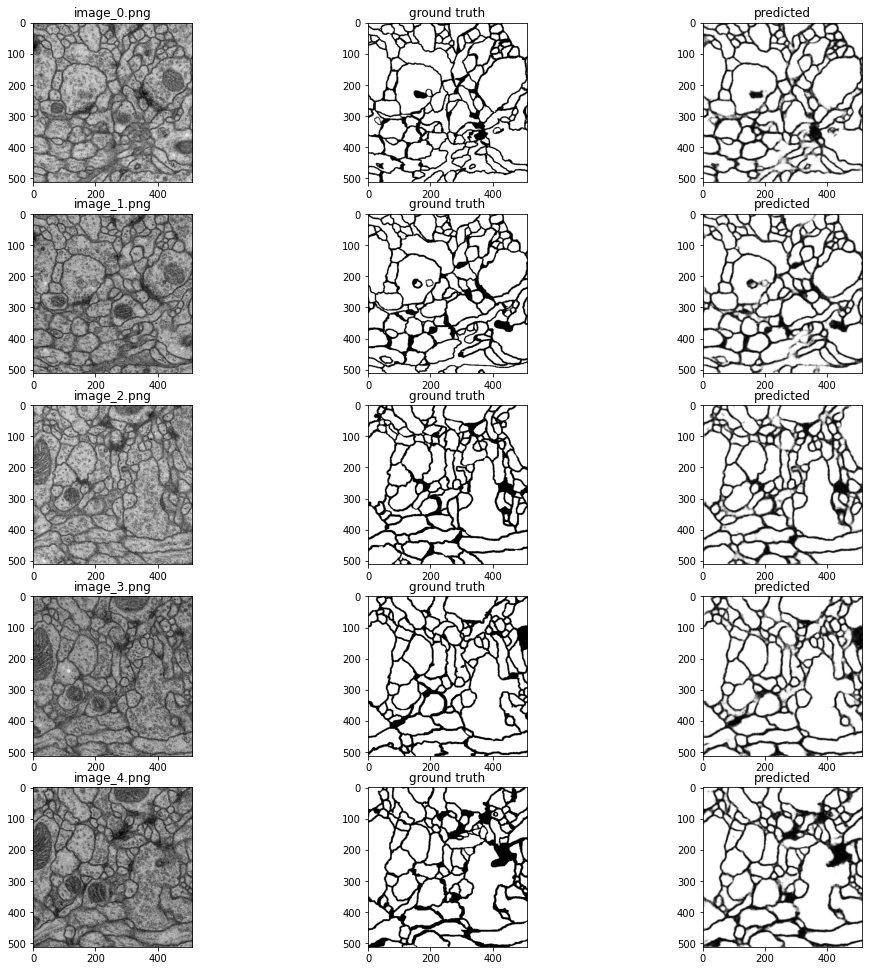

Test images: ['5', '6', '7', '8', '9']
Found 295 images belonging to 1 classes.
Found 295 images belonging to 1 classes.
Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.5820 - accuracy: 0.6782 - dice_coef: 0.7140 - jacard: 0.5626 - mean_io_u_1: 0.1104 - precision_1: 0.7832 - recall_1: 0.8134Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
60/60 [==============================] - 17s 230ms/step - loss: 0.5806 - accuracy: 0.6794 - dice_coef: 0.7150 - jacard: 0.5639 - mean_io_u_1: 0.1104 - precision_1: 0.7832 - recall_1: 0.8155 - val_loss: 0.5606 - val_accuracy: 0.7952 - val_dice_coef: 0.7029 - val_jacard: 0.5419 - val_mean_io_u_1: 0.1024 - val_precision_1: 0.7952 - val_recall_1: 1.0000

Epoch 00001: loss improved from inf to 0.49924, saving model to /content/drive/MyDrive/data/augmentation/checkpoints/fold_1_unet_ISBI2012.hdf5
Epoch 2/30
60/60 [==============================] - 13s 214ms/step - loss: 0.4006 - accuracy: 0.8026 - dice_coef

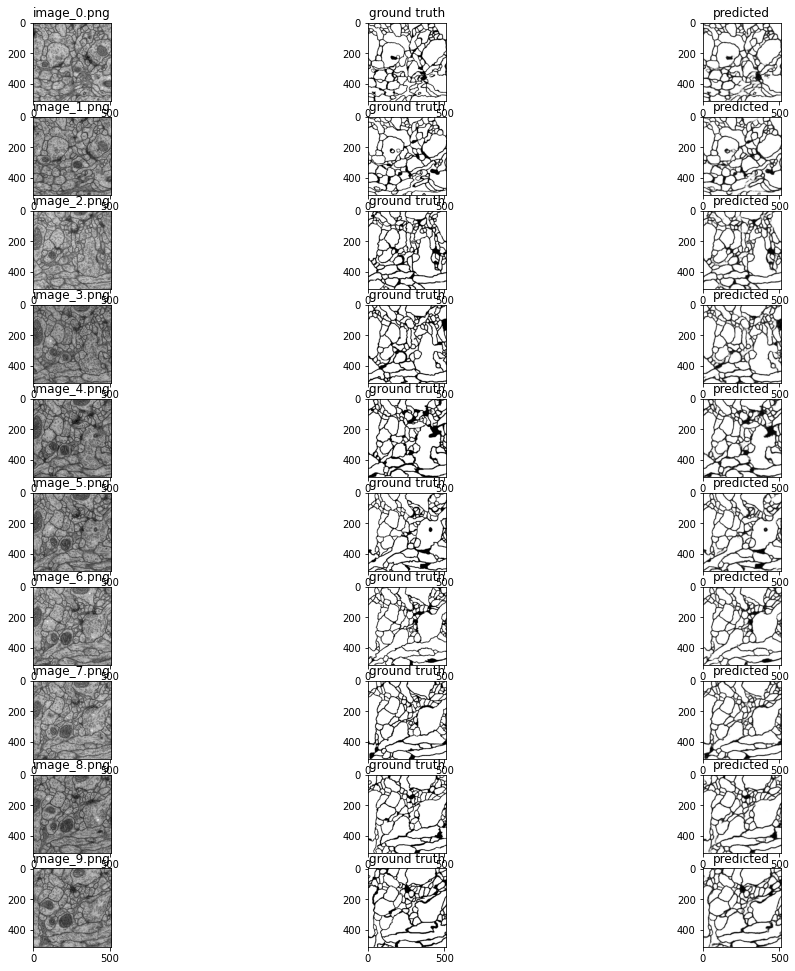

Test images: ['10', '11', '12', '13', '14']
Found 295 images belonging to 1 classes.
Found 295 images belonging to 1 classes.
Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.5532 - accuracy: 0.7263 - dice_coef: 0.7335 - jacard: 0.5843 - mean_io_u_2: 0.1106 - precision_2: 0.7860 - recall_2: 0.8931Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
60/60 [==============================] - 18s 232ms/step - loss: 0.5522 - accuracy: 0.7270 - dice_coef: 0.7343 - jacard: 0.5853 - mean_io_u_2: 0.1105 - precision_2: 0.7860 - recall_2: 0.8942 - val_loss: 0.5526 - val_accuracy: 0.7808 - val_dice_coef: 0.7105 - val_jacard: 0.5509 - val_mean_io_u_2: 0.1096 - val_precision_2: 0.7808 - val_recall_2: 1.0000

Epoch 00001: loss improved from inf to 0.49213, saving model to /content/drive/MyDrive/data/augmentation/checkpoints/fold_2_unet_ISBI2012.hdf5
Epoch 2/30
60/60 [==============================] - 13s 217ms/step - loss: 0.4029 - accuracy: 0.8028 - dice

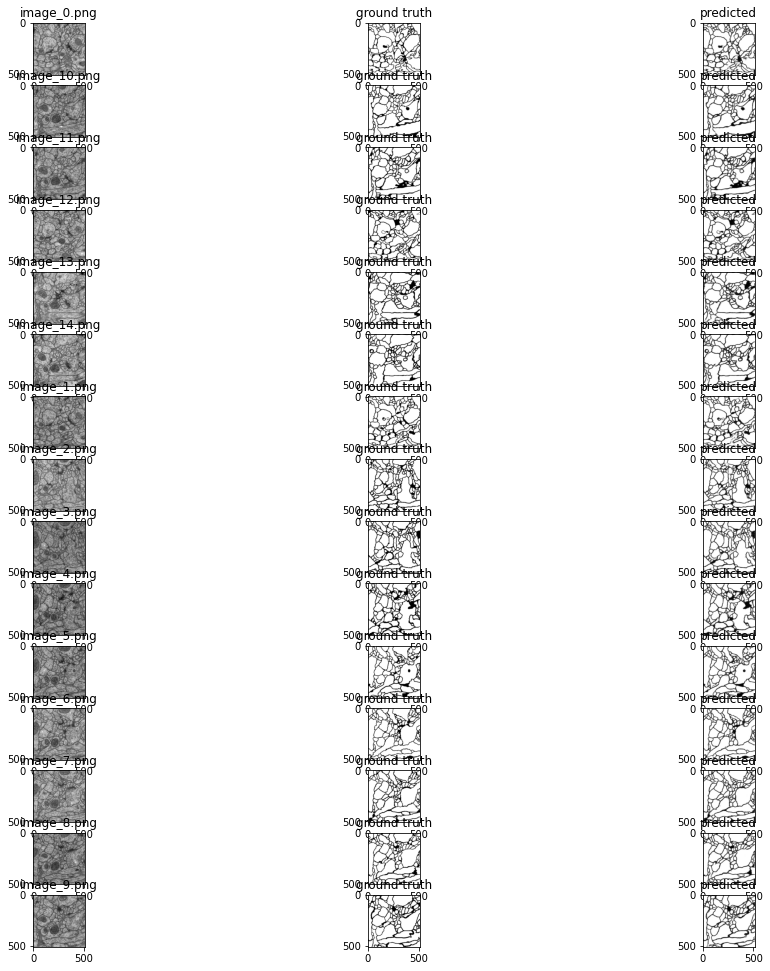

Test images: ['15', '16', '17', '18', '19']
Found 295 images belonging to 1 classes.
Found 295 images belonging to 1 classes.
Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.5441 - accuracy: 0.7277 - dice_coef: 0.7369 - jacard: 0.5887 - mean_io_u_3: 0.1109 - precision_3: 0.7814 - recall_3: 0.9033Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
60/60 [==============================] - 17s 235ms/step - loss: 0.5430 - accuracy: 0.7283 - dice_coef: 0.7377 - jacard: 0.5897 - mean_io_u_3: 0.1109 - precision_3: 0.7814 - recall_3: 0.9044 - val_loss: 0.5266 - val_accuracy: 0.8018 - val_dice_coef: 0.7315 - val_jacard: 0.5767 - val_mean_io_u_3: 0.0991 - val_precision_3: 0.8018 - val_recall_3: 1.0000

Epoch 00001: loss improved from inf to 0.47696, saving model to /content/drive/MyDrive/data/augmentation/checkpoints/fold_3_unet_ISBI2012.hdf5
Epoch 2/30
60/60 [==============================] - 14s 232ms/step - loss: 0.3841 - accuracy: 0.8109 - dice

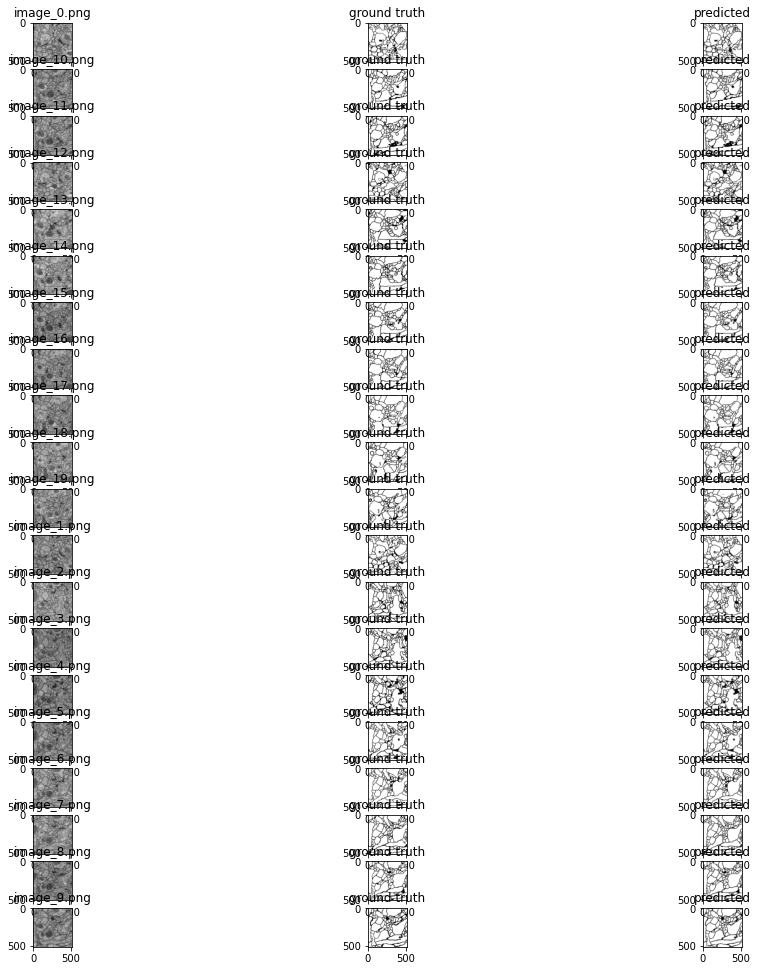

Test images: ['20', '21', '22', '23', '24']
Found 295 images belonging to 1 classes.
Found 295 images belonging to 1 classes.
Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.5627 - accuracy: 0.7122 - dice_coef: 0.7301 - jacard: 0.5806 - mean_io_u_4: 0.1109 - precision_4: 0.7768 - recall_4: 0.8835Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
60/60 [==============================] - 18s 243ms/step - loss: 0.5616 - accuracy: 0.7130 - dice_coef: 0.7309 - jacard: 0.5816 - mean_io_u_4: 0.1109 - precision_4: 0.7769 - recall_4: 0.8849 - val_loss: 0.5209 - val_accuracy: 0.7803 - val_dice_coef: 0.7390 - val_jacard: 0.5861 - val_mean_io_u_4: 0.1098 - val_precision_4: 0.7803 - val_recall_4: 1.0000

Epoch 00001: loss improved from inf to 0.49527, saving model to /content/drive/MyDrive/data/augmentation/checkpoints/fold_4_unet_ISBI2012.hdf5
Epoch 2/30
60/60 [==============================] - 13s 218ms/step - loss: 0.4036 - accuracy: 0.7950 - dice

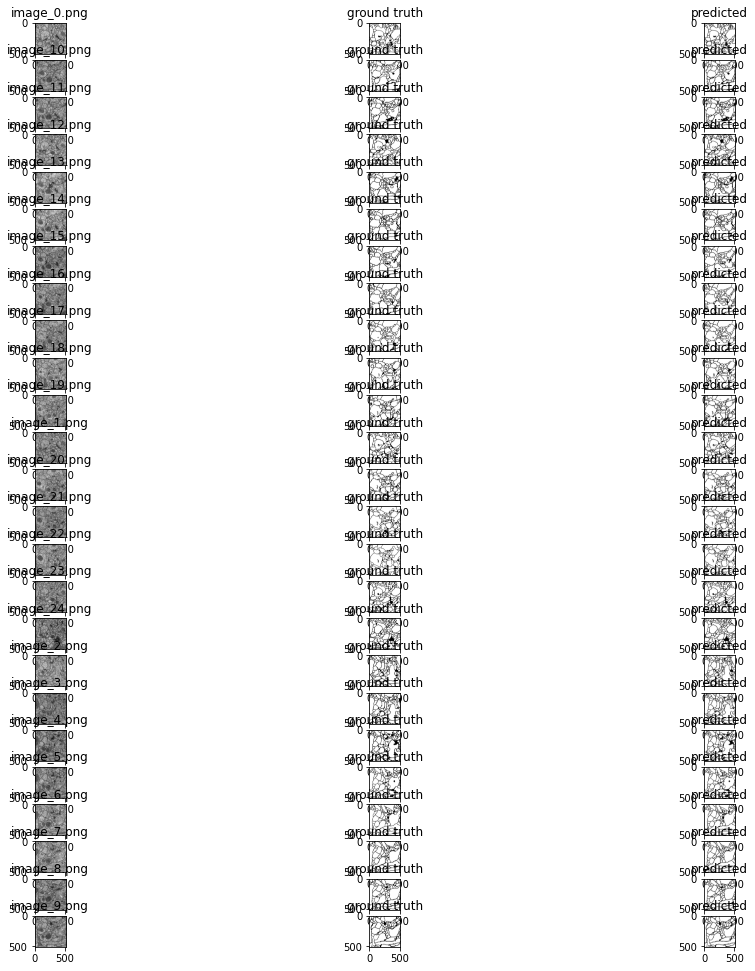

Test images: ['25', '26', '27', '28', '29']
Found 295 images belonging to 1 classes.
Found 295 images belonging to 1 classes.
Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.5407 - accuracy: 0.7607 - dice_coef: 0.7487 - jacard: 0.6016 - mean_io_u_5: 0.1103 - precision_5: 0.7788 - recall_5: 0.9679Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
60/60 [==============================] - 18s 244ms/step - loss: 0.5398 - accuracy: 0.7609 - dice_coef: 0.7493 - jacard: 0.6024 - mean_io_u_5: 0.1103 - precision_5: 0.7789 - recall_5: 0.9683 - val_loss: 0.5615 - val_accuracy: 0.7576 - val_dice_coef: 0.6994 - val_jacard: 0.5378 - val_mean_io_u_5: 0.1212 - val_precision_5: 0.7576 - val_recall_5: 1.0000

Epoch 00001: loss improved from inf to 0.49144, saving model to /content/drive/MyDrive/data/augmentation/checkpoints/fold_5_unet_ISBI2012.hdf5
Epoch 2/30
60/60 [==============================] - 13s 226ms/step - loss: 0.4153 - accuracy: 0.7929 - dice

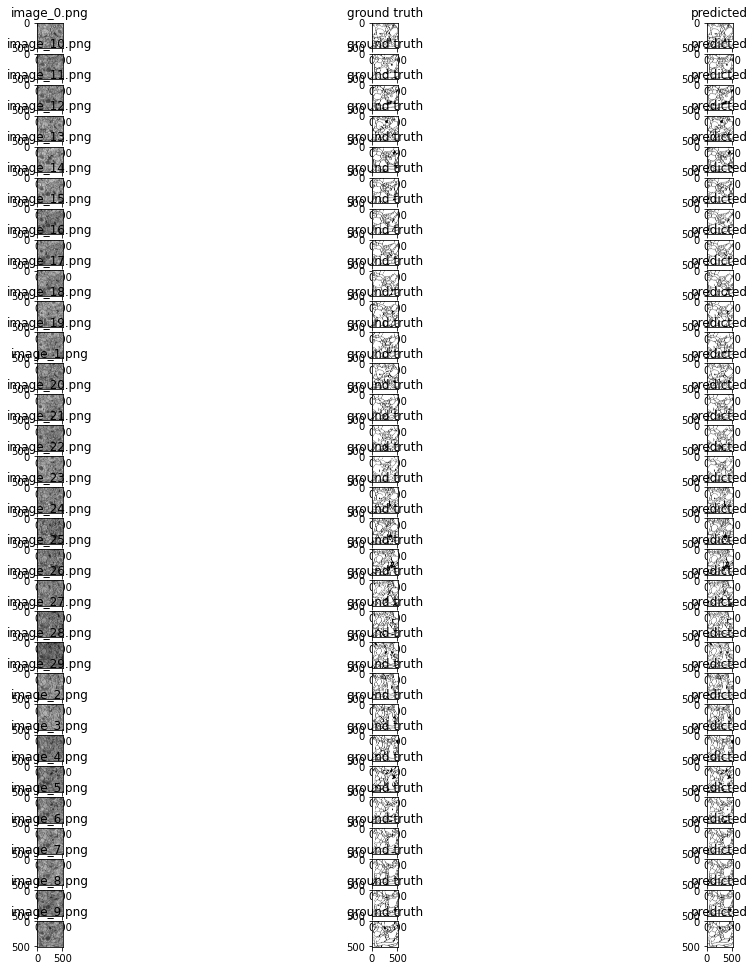

In [ ]:
k_fold(epoch=30,train_batch_size=5,test_batch_size=5,k=5,show_samples=True)

## Mean Values of Metrics 

In [ ]:
mean_metrics = np.zeros((1,14))

for idx,item in enumerate(sorted(os.listdir(LOG_PATH))):
  print("METRICS FOR FOLD {}".format(idx))
  print(50*"-")
  log_file = open(LOG_PATH + "/"+ item, "rb")
  output = pickle.load(log_file)
  i = 0
  for key, value in output.items():
    print(key + " --> " + str(value[4]))
    mean_metrics[0][i] = mean_metrics[0][i] + value[4]
    i = i+1
  print(50*"-")

mean_metrics = mean_metrics/6

mean_metrics